# Ratio Approach (Load Factor)

In [1]:
import os
os.chdir("../../")

import numpy as np
import pandas as pd

from scripts.python.tsa.mtsmodel import *
from scripts.python.tsa.ts_eval import *

import seaborn as sns
sns.set_style("whitegrid")
import matplotlib.pyplot as plt


PALAU's Official and Avaition Data.

 Create Loaded Factor for PALAU:

 Regression PALAU:
                            OLS Regression Results                            
Dep. Variable:                  ratio   R-squared:                       0.757
Model:                            OLS   Adj. R-squared:                  0.712
Method:                 Least Squares   F-statistic:                     13.44
Date:                Wed, 14 Jun 2023   Prob (F-statistic):           1.75e-08
Time:                        10:19:56   Log-Likelihood:                 33.066
No. Observations:                  45   AIC:                            -50.13
Df Residuals:                      37   BIC:                            -35.68
Df Model:                           7                                         
Covariance Type:                  HAC                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
----------------------------

/Users/czhang/miniforge3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,date,ratio,total,seats_arrivals_intl,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper,pred_mean
0,2019-01-01,0.561695,7329.0,13048.0,0.568892,0.063856,0.443738,0.694047,0.288562,0.849223,7422.908852
1,2019-02-01,0.734282,9752.0,13281.0,0.618457,0.056377,0.507960,0.728954,0.344356,0.892558,8213.728390
2,2019-03-01,0.701865,9033.0,12870.0,0.620869,0.056211,0.510697,0.731041,0.346899,0.894839,7990.583924
3,2019-04-01,0.777809,8405.0,10806.0,0.590318,0.070420,0.452297,0.728340,0.304011,0.876625,6378.979940
4,2019-05-01,0.651848,7478.0,11472.0,0.494435,0.098075,0.302212,0.686658,0.178411,0.810459,5672.158297


,MSE,RMSE,MAE,SMAPE
mean,1.219030e+07,3491.460526,3125.890370,130.888109
naive,1.298621e+06,1139.570483,677.477273,53.868245
ratio,5.220592e+05,722.536632,403.159217,41.454946


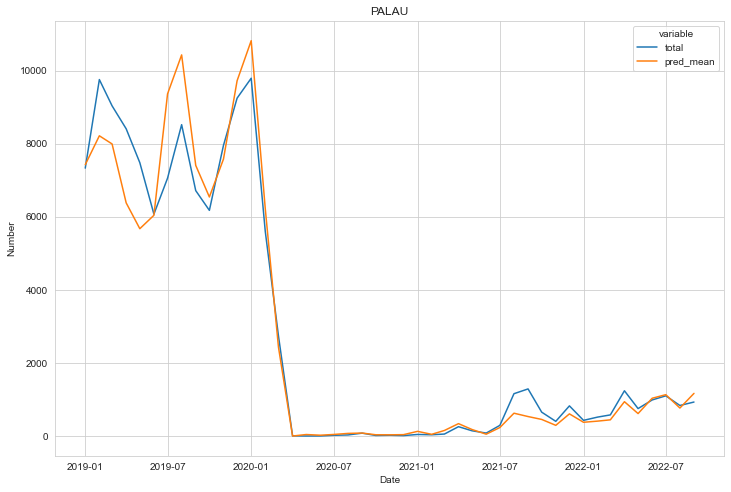


SAMOA's Official and Avaition Data.

 Create Loaded Factor for SAMOA:

 Regression SAMOA:
                            OLS Regression Results                            
Dep. Variable:                  ratio   R-squared:                       0.850
Model:                            OLS   Adj. R-squared:                  0.822
Method:                 Least Squares   F-statistic:                     50.85
Date:                Wed, 14 Jun 2023   Prob (F-statistic):           4.55e-17
Time:                        10:19:57   Log-Likelihood:                 30.672
No. Observations:                  45   AIC:                            -45.34
Df Residuals:                      37   BIC:                            -30.89
Df Model:                           7                                         
Covariance Type:                  HAC                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
----------------------------

/Users/czhang/miniforge3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,date,ratio,total,seats_arrivals_intl,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper,pred_mean
0,2019-01-01,0.522368,13755.0,26332.0,0.621337,0.065119,0.493705,0.748968,0.327609,0.915064,16361.033442
1,2019-02-01,0.522171,9044.0,17320.0,0.546506,0.052126,0.444341,0.648670,0.262915,0.830096,9465.476885
2,2019-03-01,0.535575,11163.0,20843.0,0.527865,0.060020,0.410228,0.645502,0.238340,0.817390,11002.290740
3,2019-04-01,0.692899,14413.0,20801.0,0.573619,0.095068,0.387289,0.759948,0.250038,0.897200,11931.843012
4,2019-05-01,0.650818,13565.0,20843.0,0.661691,0.048354,0.566918,0.756464,0.380679,0.942704,13791.631497


,MSE,RMSE,MAE,SMAPE
mean,4.747392e+07,6890.131975,6027.062716,155.537953
naive,7.970104e+06,2823.137282,1518.795455,49.120902
ratio,2.107651e+06,1451.775046,763.990597,131.108537


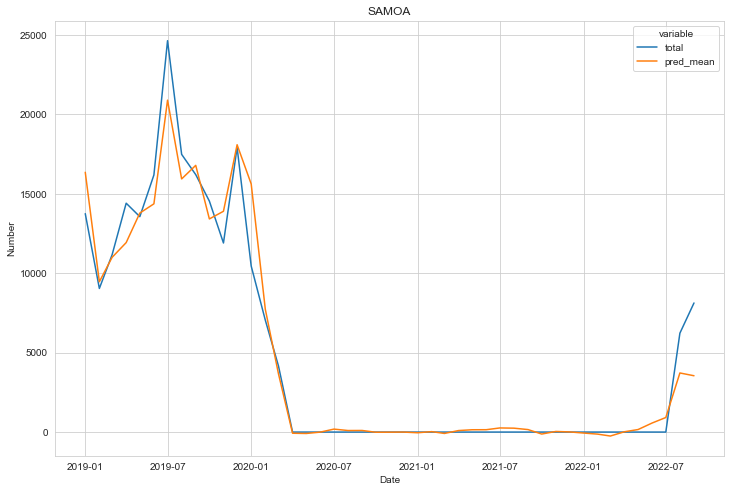


TONGA's Official and Avaition Data.

 Create Loaded Factor for TONGA:

 Regression TONGA:
                            OLS Regression Results                            
Dep. Variable:                  ratio   R-squared:                       0.953
Model:                            OLS   Adj. R-squared:                  0.941
Method:                 Least Squares   F-statistic:                     81.33
Date:                Wed, 14 Jun 2023   Prob (F-statistic):           6.54e-17
Time:                        10:19:58   Log-Likelihood:                 60.571
No. Observations:                  36   AIC:                            -105.1
Df Residuals:                      28   BIC:                            -92.47
Df Model:                           7                                         
Covariance Type:                  HAC                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
----------------------------

/Users/czhang/miniforge3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,date,ratio,total,seats_arrivals_intl,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper,pred_mean
0,2019-01-01,0.297294,4372,14706.0,0.359100,0.053865,0.253527,0.464674,0.213704,0.504496,5280.927090
1,2019-02-01,0.278131,2709,9740.0,0.360868,0.051441,0.260045,0.461691,0.218884,0.502852,3514.852693
2,2019-03-01,0.303732,3109,10236.0,0.363279,0.048249,0.268712,0.457845,0.225667,0.500890,3718.522264
3,2019-04-01,0.394065,4183,10615.0,0.439962,0.028537,0.384030,0.495894,0.325408,0.554515,4670.193497
4,2019-05-01,0.435655,5166,11858.0,0.447279,0.026097,0.396130,0.498428,0.334983,0.559575,5303.835766


,MSE,RMSE,MAE,SMAPE
mean,7.898678e+06,2810.458659,2511.586420,147.552078
naive,1.045461e+06,1022.477747,597.257143,69.556373
ratio,2.036229e+05,451.245944,258.523902,87.345914


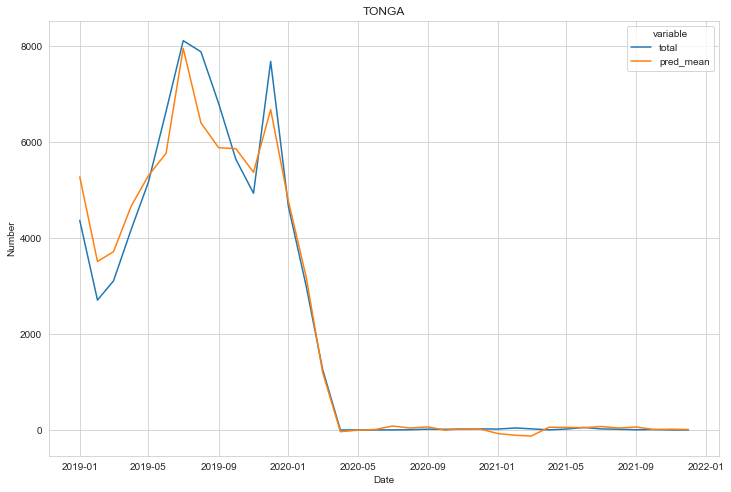


SOLOMON_ISLANDS's Official and Avaition Data.

 Create Loaded Factor for SOLOMON_ISLANDS:

 Regression SOLOMON_ISLANDS:
                            OLS Regression Results                            
Dep. Variable:                  ratio   R-squared:                       0.939
Model:                            OLS   Adj. R-squared:                  0.913
Method:                 Least Squares   F-statistic:                     239.4
Date:                Wed, 14 Jun 2023   Prob (F-statistic):           5.56e-15
Time:                        10:19:59   Log-Likelihood:                 54.264
No. Observations:                  24   AIC:                            -92.53
Df Residuals:                      16   BIC:                            -83.10
Df Model:                           7                                         
Covariance Type:                  HAC                                         
                             coef    std err          z      P>|z|      [0.025      0.975

,date,ratio,total,seats_arrivals_intl,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper,pred_mean
0,2019-01-01,0.174372,1750,10036.0,0.212880,0.017130,0.179306,0.246454,0.143644,0.282117,2136.464988
1,2019-02-01,0.199662,1891,9471.0,0.208311,0.014280,0.180324,0.236299,0.141605,0.275018,1972.917412
2,2019-03-01,0.245332,2378,9693.0,0.201838,0.018773,0.165043,0.238632,0.130984,0.272691,1956.411325
3,2019-04-01,0.220940,2106,9532.0,0.242741,0.008395,0.226287,0.259196,0.179994,0.305489,2313.809745
4,2019-05-01,0.246881,2434,9859.0,0.252211,0.016863,0.219161,0.285261,0.183227,0.321195,2486.545575


,MSE,RMSE,MAE,SMAPE
mean,1.290167e+06,1135.855000,1065.215278,100.969388
naive,1.721267e+05,414.881597,268.478261,46.835106
ratio,4.875343e+04,220.801780,150.232442,26.614403


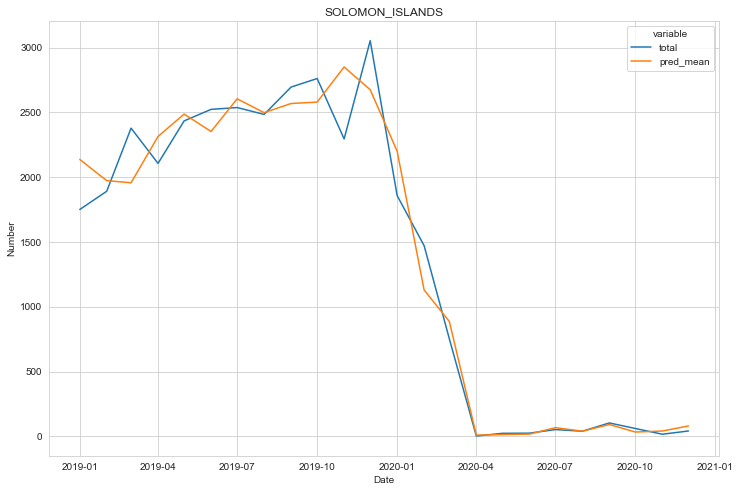


VANUATU's Official and Avaition Data.

 Create Loaded Factor for VANUATU:

 Regression VANUATU:
                            OLS Regression Results                            
Dep. Variable:                  ratio   R-squared:                       0.952
Model:                            OLS   Adj. R-squared:                  0.943
Method:                 Least Squares   F-statistic:                     61.08
Date:                Wed, 14 Jun 2023   Prob (F-statistic):           9.75e-18
Time:                        10:20:00   Log-Likelihood:                 55.431
No. Observations:                  43   AIC:                            -94.86
Df Residuals:                      35   BIC:                            -80.77
Df Model:                           7                                         
Covariance Type:                  HAC                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
----------------------

/Users/czhang/miniforge3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,date,ratio,total,seats_arrivals_intl,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper,pred_mean
0,2019-01-01,0.514218,9548.0,18568.0,0.587535,0.066177,0.457829,0.717240,0.393113,0.781956,10909.344103
1,2019-02-01,0.426535,5835.0,13680.0,0.571710,0.068540,0.437375,0.706046,0.374170,0.769250,7820.994292
2,2019-03-01,0.475565,7026.0,14774.0,0.598634,0.064663,0.471896,0.725372,0.406180,0.791088,8844.219480
3,2019-04-01,0.553277,9445.0,17071.0,0.639558,0.046125,0.549155,0.729961,0.468827,0.810288,10917.890355
4,2019-05-01,0.498628,8359.0,16764.0,0.611411,0.048101,0.517135,0.705687,0.438599,0.784223,10249.693376


,MSE,RMSE,MAE,SMAPE
mean,2.273834e+07,4768.473803,4264.861006,156.566459
naive,2.446383e+06,1564.091833,808.452381,45.153360
ratio,6.421134e+05,801.319782,497.354972,128.023752


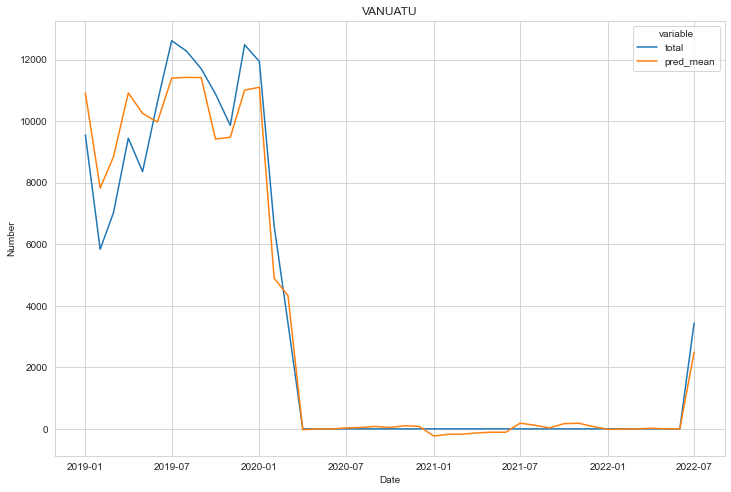

In [4]:
for country in ["palau", "samoa", "tonga", "solomon_islands", "vanuatu"]:

    mod = RatioPipe(country=country, data=None)
    print(f"\n{country.upper()}'s Official and Avaition Data.")
    mod.read_and_merge()

    print(f"\n Create Loaded Factor for {country.upper()}:")
    mod.transform()

    optimal_lag = int(4 * (len(mod.data)/100) ** (2/9)) + 1
    print(f"\n Regression {country.upper()}:")
    mod.fit(formula="ratio~covid * stringency_index+C(quarter)+"+str(country)+"_travel",
            maxlags=optimal_lag)
    pred_df = mod.get_prediction_df()

    mean_pred, naive_pred = \
        mean_method(pred_df["total"]), naive_method(pred_df["total"])

    benchmark = pd.DataFrame()
    eval_name = ["mean", "naive", "ratio"]
    for idx, pred in zip(eval_name, [mean_pred, naive_pred, pred_df["pred_mean"]]):
        eval_df = pd.DataFrame(calculate_evaluation(
            pred_df["total"], pred), index=[idx])
        benchmark = pd.concat([benchmark, eval_df])
    display(benchmark)

    benchmark.to_csv(mod.country_data_folder + "/model/lf_eval_" + str(country) + ".csv",
                     encoding="utf-8")

    saved_pred_path = mod.country_data_folder + \
        "/model/lf_" + str(country) + ".csv"
    pred_df.to_csv(saved_pred_path, encoding="utf-8")

    ratio_viz_df = pred_df[["date", "total", "pred_mean"]].melt(id_vars="date")
    fig, ax = plt.subplots(figsize=(12, 8))
    sns.lineplot(data=ratio_viz_df, x="date", y="value", hue="variable")
    ax.set(xlabel="Date", ylabel="Number", title=str(country).upper())
    plt.show()